# Synchrotron-radiation event generator from Synrad+ table

## authors: Reynier Cruz-Torres*, Benjamen Sterwerf**
#### -* Lawrence Berkeley National Laboratory
#### -** University of California, Berkeley

-----

Point the code to a yaml config file in the next cell. That should be the only input needed. This config file is expected to contain the following variables:

- ```input_single_photons```: path to csv file containing the reformatted synrad+ single photons to be combined into events.
- ```n_events```: number of events to be generated.
- ```integration_window```: time window that will define one event.
- ```seed```: random seed for reproducibility. Set to 0 to leave the seed unconstrained.

-----

Libraries needed to run this notebook: ```yaml```, ```numpy```, ```matplotlib.pyplot```, ```pandas```, ```pyhepmc_ng```, ```ROOT```, ```os``` and ```time```.

In [1]:
config = 'config.yaml'

### Nothing needs to be changed below this line

-----

Loading input from user

In [2]:
import yaml

with open(config,'r') as stream:
    conf_dict = yaml.safe_load(stream)
    
input_single_photons = conf_dict['input_single_photons']
n_events = conf_dict['n_events']
integration_window = conf_dict['integration_window']
seed = conf_dict['seed']

Some additional imports and parameters

In [3]:
import numpy as np
import pandas as pd
#import pyhepmc_ng as hep
import pyhepmc as hep
import matplotlib.pyplot as plt

import ROOT
if seed > 0:
    ROOT.gRandom.SetSeed(seed)
ROOT.gStyle.SetOptStat(0)

import time
t0 = time.time()

import os
outpath = 'output_plots'
if not os.path.exists(outpath):
    os.makedirs(outpath)

Welcome to JupyROOT 6.26/06


Setting some important variables

In [4]:
pid = 22 # 22 = photon, can be changed for testing
status_000 = 4 # try 1, 2, or 4 (see page 31 in https://arxiv.org/pdf/1912.08005.pdf)
status_xyz = 1

if seed > 0:
    outfname = 'out_int_window_{}ns_nevents_{}_pid_{}_status_{}_{}_seed_{}.hepmc'.format(
        integration_window*1e+09,n_events,pid,status_000,status_xyz,seed)
else:
    outfname = 'out_int_window_{}ns_nevents_{}_pid_{}_status_{}_{}.hepmc'.format(
        integration_window*1e+09,n_events,pid,status_000,status_xyz)

#### Loading input data

In [5]:
df = pd.read_csv(input_single_photons)
df = df.sort_values('NormFact')

# x, y, z are in mm, and px, py, pz in GeV
df.head()

,x,y,z,px,py,pz,NormFact
1620504,28.2006,8.29940,-3078.390,0.0,0.0,-0.0,0.0
1420970,-27.0238,-11.58470,-3383.230,-0.0,-0.0,-0.0,0.0
1323913,-25.2181,-15.22080,-706.387,-0.0,-0.0,-0.0,0.0
1035621,25.6664,-14.49560,-3924.800,0.0,-0.0,-0.0,0.0
845663,29.0895,-4.69247,-3911.200,0.0,-0.0,-0.0,0.0


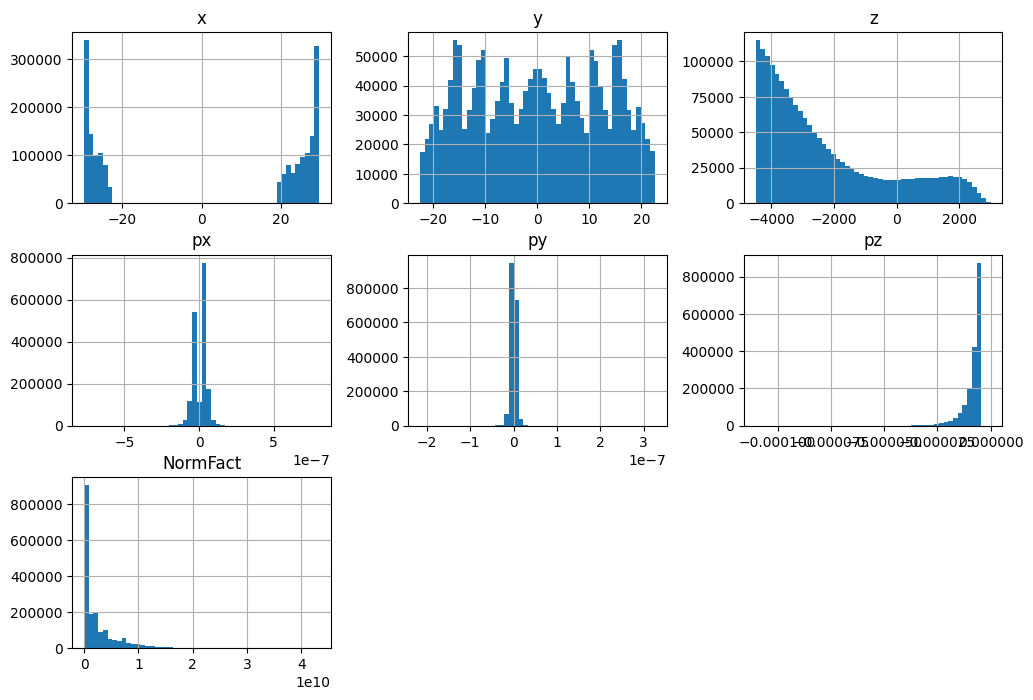

In [6]:
df.hist(figsize=(12,8),bins=50)
plt.show()

In [7]:
# Uncomment lines below for correlation matrix. It just takes a while for it to run
#from pandas.plotting import scatter_matrix
#attributes = ['x','y','z','px','py','pz','NormFact']
#scatter_matrix(df,figsize=(12,8))
#plt.savefig('scatter_matrix.png',dpi=600)

#### Creating 1D histogram that will be turned into a generator

In [8]:
n_entries = len(df)
h1_df = ROOT.TH1D('h1_df',';entry;W [#gamma/sec]',n_entries,0,n_entries)
for i in range(n_entries):
    h1_df.SetBinContent(i+1,df['NormFact'].iloc[i])

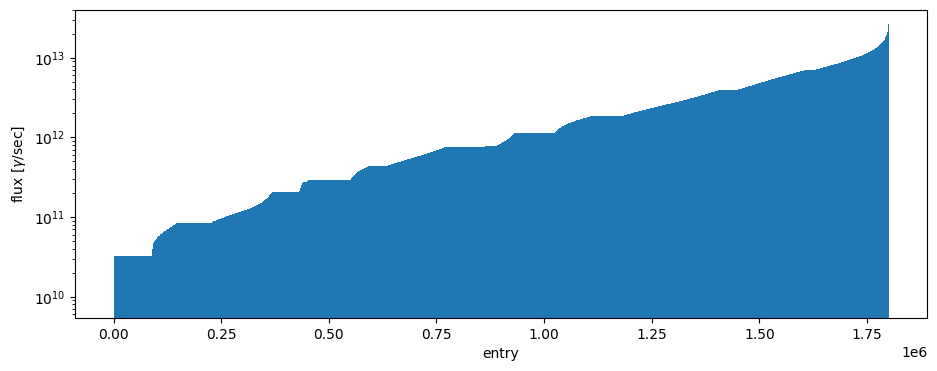

In [9]:
plt.figure(figsize=(11,4))
x = np.linspace(0,1800000,1800000)
plt.hist(x,weights=df['NormFact'],bins=1800)
plt.yscale('log')
plt.xlabel('entry')
plt.ylabel(r'flux [$\gamma$/sec]')
plt.savefig('output_plots/generator.png',dpi=400)
plt.show()

#### Implementing the event generator

In [10]:
def generate_an_event(integration_window):

    event = []
    integrated_so_far = 0.
    
    while integrated_so_far < integration_window:
        x = h1_df.FindBin(h1_df.GetRandom())
        
        if x >= 1800000:
            continue
        
        photon = df.iloc[x]

        integrated_so_far += 1./photon['NormFact']
        event.append(photon)
        
    return event

#### Generating events and saving them to hepmc files

In [11]:
h_n_photons_per_event = ROOT.TH1D('h_n_photons_per_event','',50,100,400)

events = []
hep_events = []
photons_per_event = []
z_dist = []
rho_dist = []

#f = hep.WriterAscii(outfname)

for i in range(n_events):
    event = generate_an_event(integration_window)
    
    # ---------------------------------------------------
    # Save to hepmc format
    # implemented following the example from:
    # https://github.com/scikit-hep/pyhepmc/blob/master/tests/test_basic.py
    evt = hep.GenEvent(hep.Units.GEV, hep.Units.MM)
    evt.event_number = i+1
    particles_out = []
    particles_in = []
    vertices = []
    
    # loop over each photon in the event
    for g in range(len(event)):
        
        x = event[g]['x']
        y = event[g]['y']
        z = event[g]['z']
        
        z_dist.append(z)
        rho_dist.append(np.sqrt(x*x+y*y))
        
        px = event[g]['px']
        py = event[g]['py']
        pz = event[g]['pz']
        E = np.sqrt(px**2 + py**2 + pz**2)
        
        pinx = E*x/np.sqrt(x*x+y*y+z*z)
        piny = E*y/np.sqrt(x*x+y*y+z*z)
        pinz = E*z/np.sqrt(x*x+y*y+z*z)
        
        # Particles going into the vertex
        pin = hep.GenParticle((pinx,piny,pinz,E),pid,status_000)
        pin.generated_mass = 0.
        evt.add_particle(pin)
        particles_in.append(pin)
        
        # Particles coming out of the vertex
        pout = hep.GenParticle((px,py,pz,E),pid,status_xyz)
        pout.generated_mass = 0.
        evt.add_particle(pout)
        particles_out.append(pout)
        
        # make sure vertex is not optimized away by WriterAscii
        v1 = hep.GenVertex((x,y,z,0.))
        v1.add_particle_in(pin)
        v1.add_particle_out(pout)
        evt.add_vertex(v1)
        vertices.append(v1)
        
    # -------------------
    #evt.weights = [1.0]
    if i == 0:
        evt.run_info = hep.GenRunInfo()
        #evt.run_info.weight_names = ["0"]
    hep_events.append(evt)
    # ---------------------------------------------------
    
    photons_per_event.append(len(event))
        
    if i < 15:
        events.append(event)
        
with hep.io.WriterAscii(outfname) as f:
    for e in hep_events:
        f.write_event(e)

#### Making some plots with the generated data

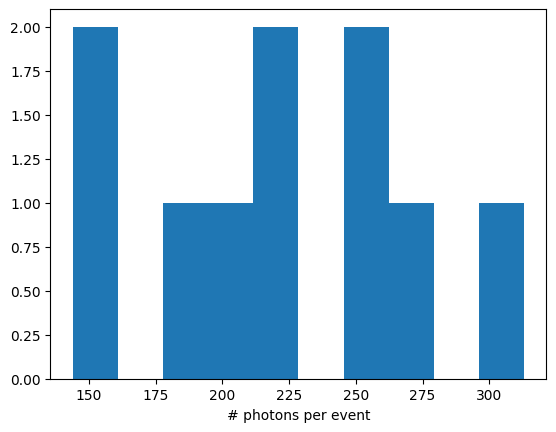

In [14]:
plt.figure()
plt.hist(photons_per_event)
plt.xlabel('# photons per event')
plt.savefig('output_plots/Nphotons_per_event.png',dpi=400)
plt.show()

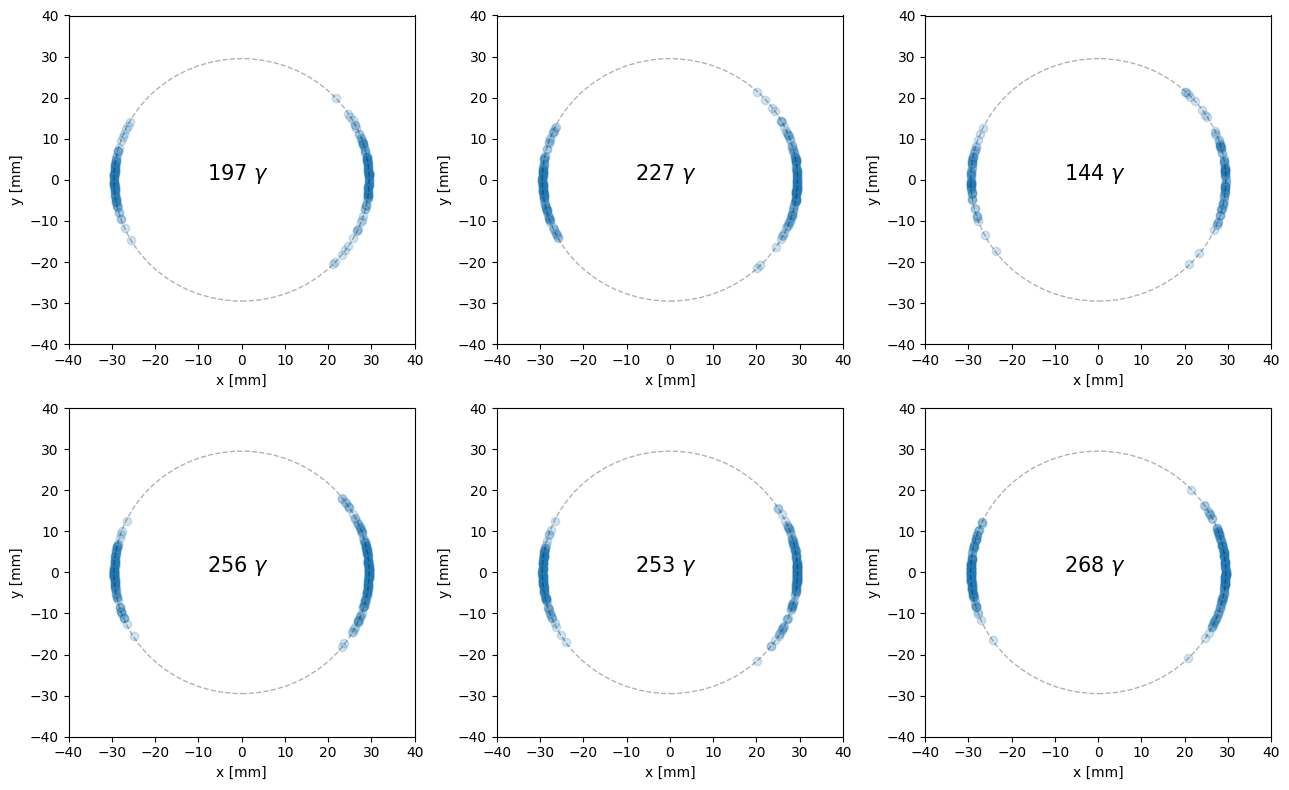

In [15]:
plt.figure(figsize=(13,8))

circle1 = plt.Circle((0, 0), 0.3, color='r')

for i in range(6):
    plt.subplot(2,3,i+1)
    
    x = []
    y = []
    P = []
    p1 = []
    
    for j in range(len(events[i])):
        x.append(events[i][j]['x'])
        y.append(events[i][j]['y'])
        P.append(np.sqrt(events[i][j]['px']**2+events[i][j]['py']**2+events[i][j]['pz']**2))
        
    min_p = min(P)
    max_p = max(P)
    for p in P:
        p1.append((p-min_p)/(max_p-min_p))
    
    plt.scatter(x,y,marker='o',alpha=0.2)
        
    plt.xlim(-40,40)
    plt.ylim(-40,40)
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    
    plt.text(-8,0,r'{} $\gamma$'.format(len(events[i])),fontsize=15)
    
    circle1 = plt.Circle((0,0), radius=29.5,color='black',fill=False,linestyle='--',alpha=0.3)
    plt.gca().add_patch(circle1)
    
plt.tight_layout()
plt.savefig('output_plots/xy.png',dpi=400)
plt.show()

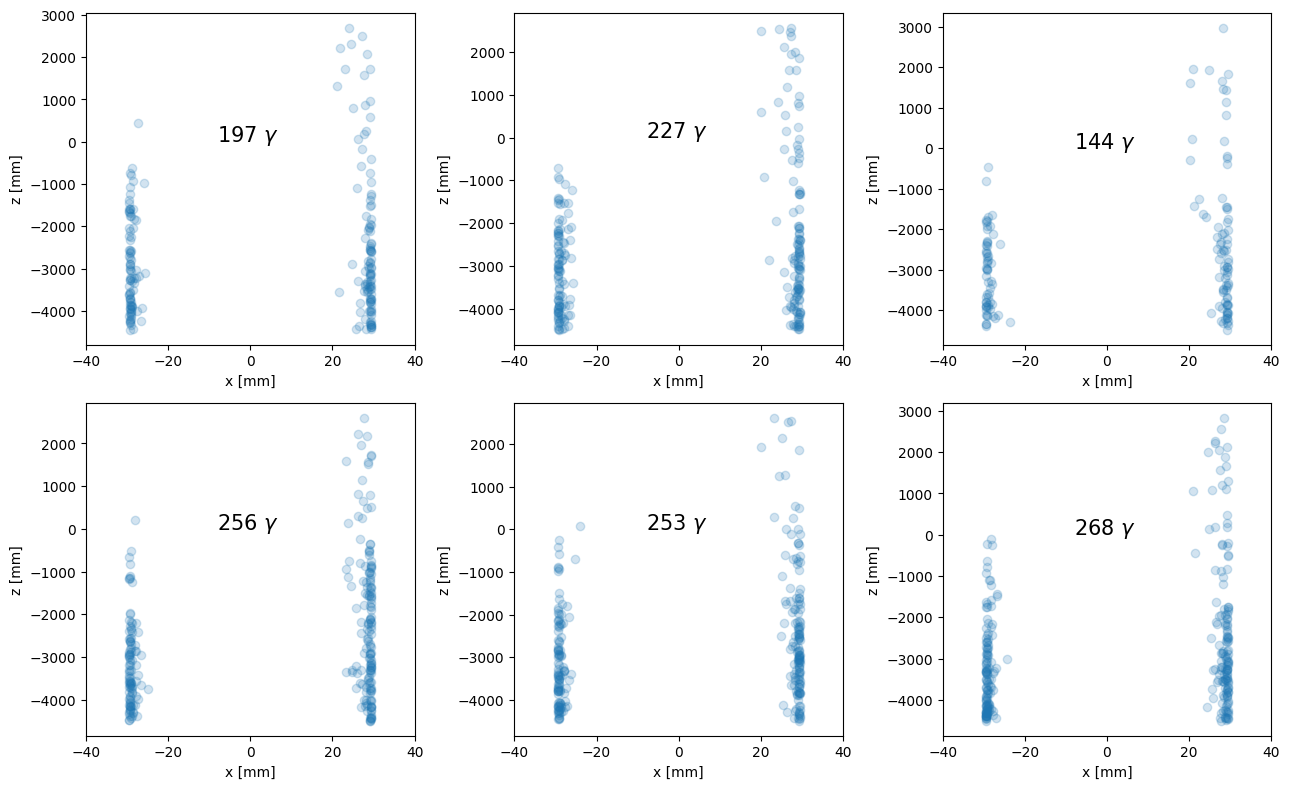

In [16]:
plt.figure(figsize=(13,8))

circle1 = plt.Circle((0, 0), 0.3, color='r')

for i in range(6):
    plt.subplot(2,3,i+1)
    
    x = []
    z = []
    
    for j in range(len(events[i])):
        x.append(events[i][j]['x'])
        z.append(events[i][j]['z'])
            
    plt.scatter(x,z,marker='o',alpha=0.2)
        
    plt.xlim(-40,40)
    plt.xlabel('x [mm]')
    plt.ylabel('z [mm]')
    
    plt.text(-8,0,r'{} $\gamma$'.format(len(events[i])),fontsize=15)
    
plt.tight_layout()
plt.savefig('output_plots/xz.png',dpi=400)
plt.show()

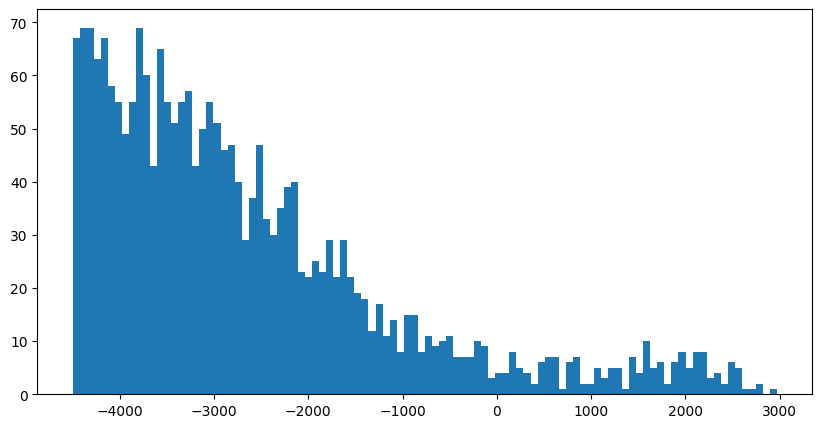

In [17]:
plt.figure(figsize=(10,5))
plt.hist(z_dist,bins=100)
plt.show()

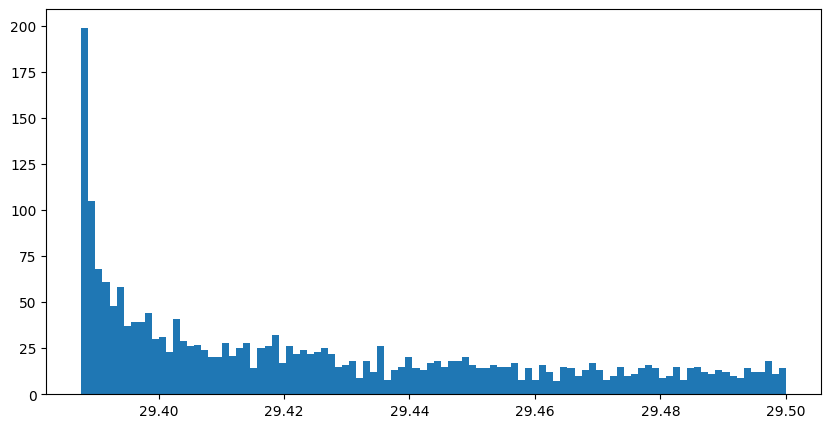

In [18]:
plt.figure(figsize=(10,5))
plt.hist(rho_dist,bins=100)
plt.show()

In [19]:
t = time.time()-t0 #sec
print('time that took to finish: ',np.round(t/60.,1),'min')

time that took to finish:  0.3 min
